## Initial setup

In [25]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [26]:
!nvidia-smi

Thu Jun 15 15:15:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |   4917MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  ERROR: HTTP error 404 while getting https://github.com/wandb/client/archive/feature/code-save.zip
ERROR: Could not install requirement https://github.com/wandb/client/archive/feature/code-save.zip because of HTTP error 404 Client Error: Not Found for url: https://codeload.github.com/wandb/wandb/zip/feature/code-save for URL https://github.com/wandb/client/archive/feature/code-save.zip


In [28]:
!pip install wandb
import wandb
wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

### Restoring model weights from GCS Bucket

In [5]:
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "fast-ai-exploration"
!gcloud config set project $PROJECT_ID

MessageError: ignored

In [ ]:
!gsutil cp gs://resnet_simclr_imagenet/20200508-134915resnet_simclr.h5 .

### Restoring model weights from `wandb` run page

In [4]:
simclr_weights = wandb.restore("20200509-042927resnet_simclr.h5", run_path="sayakpaul/simclr/simclr-learning")

In [30]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

## Dataset gathering and preparation

In [31]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 17.03 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [32]:
# Gather dataset
!git clone https://github.com/Manishnadella/Datasets

fatal: destination path 'Datasets' already exists and is not an empty directory.


In [9]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [33]:
# Train and test image paths
train_images = list(paths.list_images("Datasets/Train_emotion"))
test_images = list(paths.list_images("Datasets/Test_emotion"))
print(len(train_images), len(test_images))

1104 95


In [134]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, int(len(train_images)/20))
len(train_images_10)


55

In [103]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = cv2.cvtColor(image_pixels, cv2.COLOR_RGBA2RGB)
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[1]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [135]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

100%|██████████| 55/55 [00:00<00:00, 166.63it/s]


(55, 224, 224, 3) (55,)


100%|██████████| 95/95 [00:00<00:00, 167.94it/s]

(95, 224, 224, 3) (95,)


In [136]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Utilities

In [106]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [137]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights(simclr_weights)
resnet_simclr.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_49 (Dense)            (None, 256)               524544    
                                                                 
 activation_16 (Activation)  (None, 256)               0         
                                                                 
 dense_50 (Dense)            (None, 128)               32896     
                                                          

In [108]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [109]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

## Evaluation

In [138]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_49 (Dense)            (None, 256)               524544    
                                                                 
 activation_16 (Activation)  (None, 256)               0         
                                                                 
 dense_50 (Dense)            (None, 128)               32896     
                                                          

In [139]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

3/3 [==============================] - 0s 84ms/step
(55, 128) (95, 128)


In [140]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/35
1/1 [==============================] - 1s 663ms/step - loss: nan - accuracy: 0.2000 - val_loss: nan - val_accuracy: 0.2000
Epoch 2/35
1/1 [==============================] - 0s 35ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 3/35
1/1 [==============================] - 0s 33ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 4/35
1/1 [==============================] - 0s 34ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 5/35
1/1 [==============================] - 0s 33ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 6/35
1/1 [==============================] - 0s 49ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 7/35
1/1 [==============================] - 0s 34ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 8/35
1/1 [==============================] - 0s 33ms/step - los

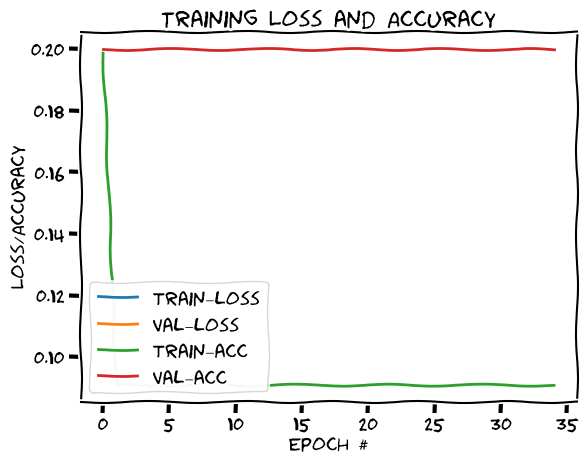

In [141]:
# Linear model
wandb.init(project="simclr", id="linear-eval-relu-last")

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 )
plot_training(history)

In [142]:
# Encoder model with less non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

3/3 [==============================] - 0s 89ms/step
(55, 256) (95, 256)


Epoch 1/20
1/1 [==============================] - 1s 961ms/step - loss: nan - accuracy: 0.1818 - val_loss: nan - val_accuracy: 0.2000
Epoch 2/20
1/1 [==============================] - 0s 61ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 3/20
1/1 [==============================] - 0s 60ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 4/20
1/1 [==============================] - 0s 63ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 5/20
1/1 [==============================] - 0s 62ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 6/20
1/1 [==============================] - 0s 61ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 7/20
1/1 [==============================] - 0s 66ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 8/20
1/1 [==============================] - 0s 47ms/step - los

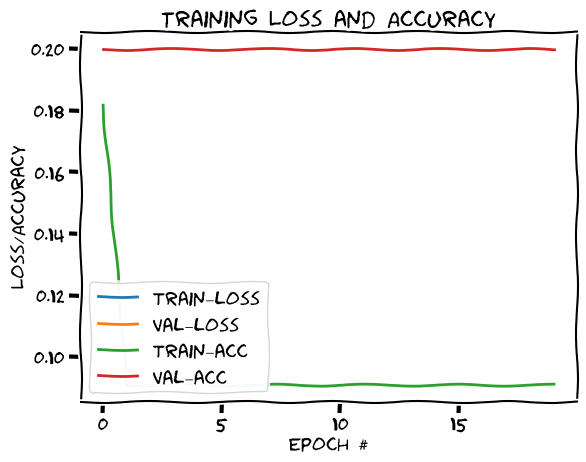

In [143]:
wandb.init(project="simclr", id="linear-eval-relu-second-last")

linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=20,
                 )
plot_training(history)

In [144]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

3/3 [==============================] - 0s 92ms/step
(55, 2048) (95, 2048)


In [ ]:
wandb.init(project="simclr", id="linear-eval-no-projections")

linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=20,
                )
plot_training(history)

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: nan - accuracy: 0.2000 - val_loss: nan - val_accuracy: 0.2000
Epoch 2/20
1/1 [==============================] - 0s 49ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 3/20
1/1 [==============================] - 0s 69ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 4/20
1/1 [==============================] - 0s 58ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 5/20
1/1 [==============================] - 0s 64ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 6/20
1/1 [==============================] - 0s 52ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 7/20
1/1 [==============================] - 0s 36ms/step - loss: nan - accuracy: 0.0909 - val_loss: nan - val_accuracy: 0.2000
Epoch 8/20
1/1 [==============================] - 0s 50ms/step - loss: 

## Visualization of the representations

In [75]:
wandb.init(project="simclr", id="visualization")

accuracy,▁█
epoch,▁█
val_accuracy,▁▁
accuracy,0.18526
epoch,1
loss,nan
val_accuracy,0.19
val_loss,nan


In [34]:
# Visualization of the representations
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.show()

    return fig

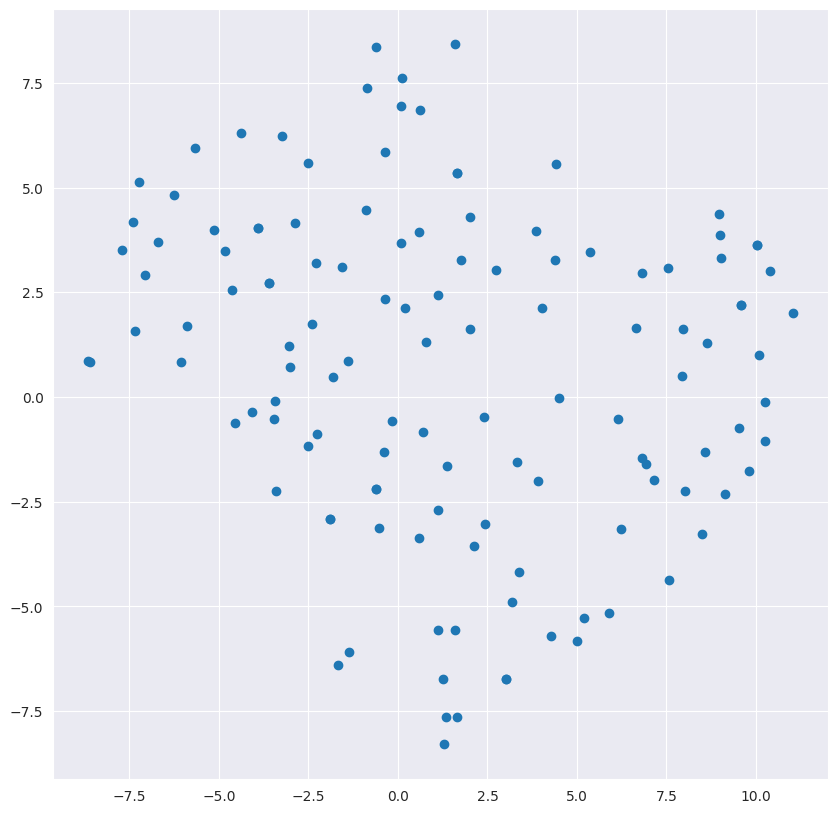

AttributeError: ignored

In [35]:
# Representations with no nonlinear projections
tsne = TSNE()
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"no_no_linear_projection": fig})

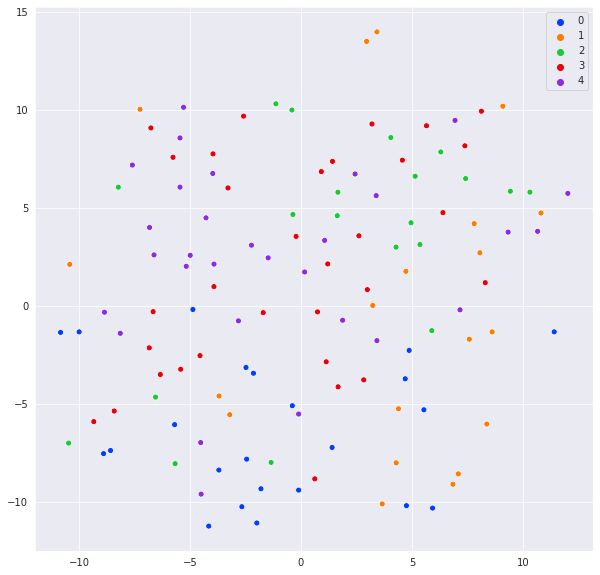

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [ ]:
# Representations with second last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"second_last_relu": fig})

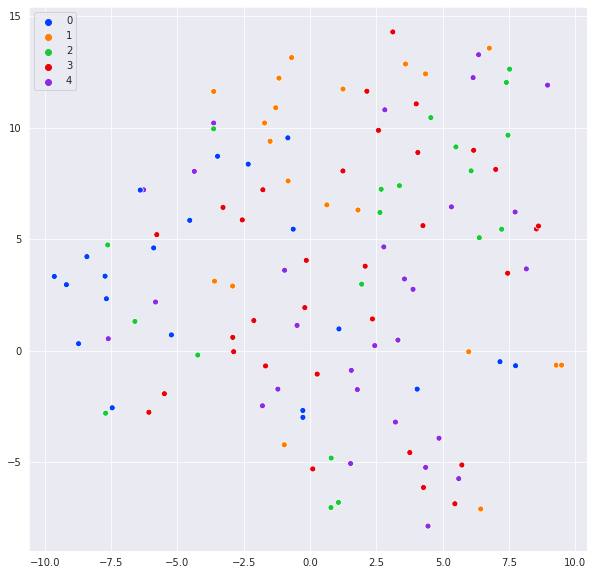

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [ ]:
# Representations with the last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"last_relu": fig})